In [1]:
%reload_kedro

2023-05-03 14:56:21,304 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/gpalazzo/Desktop/dev/crypto_msc_thesis
2023-05-03 14:56:21,828 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-05-03 14:56:21,956 - kedro.extras.extensions.ipython - INFO - ** Kedro project crypto_thesis
2023-05-03 14:56:21,957 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from crypto_thesis.data_domains.spine import spine_build_target_labels

### Label balancing

In [4]:
df_spine_preproc = catalog.load("spine_preprocessing")
df_spine_logret = catalog.load("spine_log_ret")
spine_params = catalog.load("params:spine_labeling")
spine_cls_bds_params = catalog.load("params:spine_class_bounds")

2023-05-03 14:56:23,023 - kedro.io.data_catalog - INFO - Loading data from `spine_preprocessing` (ParquetDataSet)...
2023-05-03 14:56:23,092 - kedro.io.data_catalog - INFO - Loading data from `spine_log_ret` (ParquetDataSet)...
2023-05-03 14:56:23,105 - kedro.io.data_catalog - INFO - Loading data from `params:spine_labeling` (MemoryDataSet)...
2023-05-03 14:56:23,105 - kedro.io.data_catalog - INFO - Loading data from `params:spine_class_bounds` (MemoryDataSet)...


In [5]:
# test a different tau value to evaluate class balancing
spine_params.update({"tau": 0.05})
spine_params

{'tau': 0.05}

In [6]:
df_spine_lbl = spine_build_target_labels(df=df_spine_preproc, 
                                         df_log_ret=df_spine_logret, 
                                         label_params=spine_params,
                                        class_bounds=spine_cls_bds_params)

2023-05-03 14:56:28,494 - crypto_thesis.data_domains.spine.build_labels - INFO - Checking for class balance


In [7]:
df_spine_lbl.label.value_counts() / df_spine_lbl.shape[0]

bottom    0.5
top       0.5
Name: label, dtype: float64

### Volume bar time interval plots

In [8]:
df_spine = catalog.load("spine_labeled")
df_ftes = catalog.load("fte_binance").dropna()

2023-05-03 14:56:28,510 - kedro.io.data_catalog - INFO - Loading data from `spine_labeled` (ParquetDataSet)...
2023-05-03 14:56:28,516 - kedro.io.data_catalog - INFO - Loading data from `fte_binance` (ParquetDataSet)...


In [9]:
df_spine_aux = df_spine.copy()

df_spine_aux = df_spine_aux.merge(df_ftes[["open_time", "close_time"]], \
                                  on=["open_time", "close_time"] , \
                                 how="inner")

df_spine_aux.loc[:, "open_close_duration_sec"] = (df_spine_aux["close_time"] - df_spine_aux["open_time"]).dt.total_seconds()
df_spine_aux.loc[:, "close_target_duration_sec"] = (df_spine_aux["target_time"] - df_spine_aux["close_time"]).dt.total_seconds()

df_spine_aux.loc[:, "open_close_duration_min"] = df_spine_aux["open_close_duration_sec"] / 60.0
df_spine_aux.loc[:, "close_target_duration_min"] = df_spine_aux["close_target_duration_sec"] / 60.0

In [10]:
df_spine_aux.head()

,open_time,close_time,target_time,logret_cumsum,target_time_close,target_time_log_return,close_time_close,std,close_to_tgt_time_logret,pctchg_cumsum,close_to_tgt_time_pctchg,label,open_close_duration_sec,close_target_duration_sec,open_close_duration_min,close_target_duration_min
0,2020-05-17 01:15:00,2020-05-17 17:15:00,2020-05-18 08:30:00,0.029467,9706.29,-0.007969,9751.14,0.003323,-0.004610,0.029905,-0.004599,bottom,57600.0,54900.0,960.0,915.0
1,2020-11-26 20:00:00,2020-11-27 08:45:00,2020-11-27 21:30:00,0.020019,16957.02,-0.002531,16850.85,0.005560,0.006281,0.020221,0.006301,bottom,45900.0,45900.0,765.0,765.0
2,2021-01-10 16:00:00,2021-01-10 21:00:00,2021-01-11 03:30:00,-0.044742,34152.19,-0.034282,37935.95,0.014433,-0.105072,-0.043756,-0.099741,bottom,18000.0,23400.0,300.0,390.0
3,2022-09-10 19:00:00,2022-09-10 22:15:00,2022-09-11 02:30:00,0.008199,21488.00,-0.004209,21624.20,0.002976,-0.006318,0.008233,-0.006298,bottom,11700.0,15300.0,195.0,255.0
4,2021-02-13 10:45:00,2021-02-14 05:15:00,2021-02-14 18:30:00,0.020368,48488.61,-0.005010,47970.64,0.003039,0.010740,0.020577,0.010798,bottom,66600.0,47700.0,1110.0,795.0


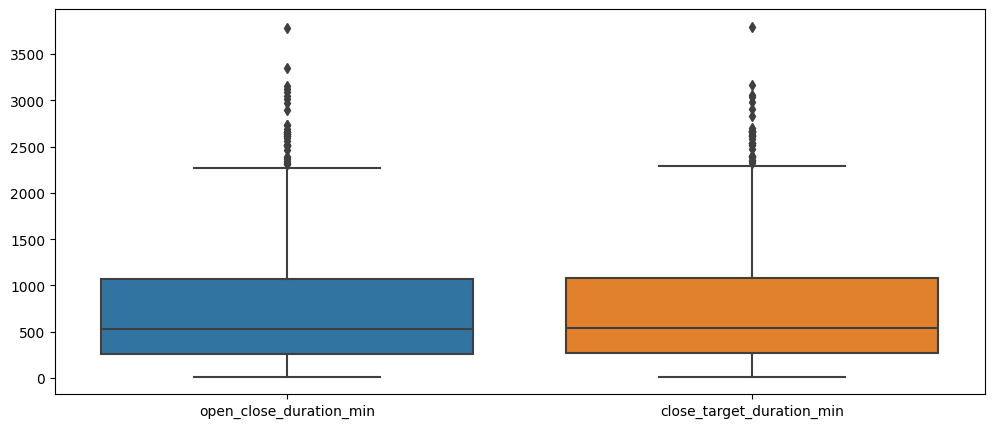

In [11]:
df_plot = df_spine_aux[["close_time", "open_close_duration_min", "close_target_duration_min"]] \
                        .set_index("close_time") \
                        .sort_index()

plt.figure(figsize=(12, 5))

# plot = sns.boxplot(data=df_plot, palette="gray")
plot = sns.boxplot(data=df_plot)

fig = plot.get_figure()
fig.savefig("/Users/gpalazzo/Desktop/fig_boxplot_time_windows.png")

In [12]:
df_plot.describe()

,open_close_duration_min,close_target_duration_min
count,1742.000000,1742.000000
mean,717.037887,729.463261
std,591.817854,586.879262
min,15.000000,15.000000
25%,255.000000,270.000000
50%,525.000000,540.000000
75%,1065.000000,1080.000000
max,3780.000000,3795.000000
